In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from learning_analysis import learning_analysis
from bias_variance_analysis import bias_variance_analysis
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.model_selection import GridSearchCV
from preprocess import *

In [3]:
# Read the preprocessed dataset
train = pd.read_csv('../dataset/train_preprocessed.csv')
X_train = train.drop('Body_Level', axis=1).to_numpy()
y_train = train['Body_Level'].to_numpy(dtype='int')
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# Read the test dataset
test = pd.read_csv('../dataset/test.csv')
test = preprocess(test)
test = remove_uncorrelated_features(test)
X_test = test.drop('Body_Level', axis=1).to_numpy()
y_test = test['Body_Level'].to_numpy(dtype='int')

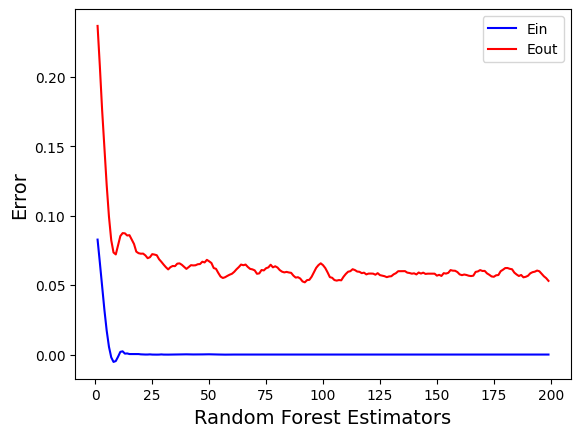

In [5]:
values = [i for i in range(1, 200)]
train_scores = []
val_scores = []
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = RandomForestClassifier(n_estimators=i)
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the validation dataset
    val_yhat = model.predict(X_val)
    val_acc = accuracy_score(y_val, val_yhat)
    val_scores.append(val_acc)
    
train_loss = [1 - i for i in train_scores]
val_loss = [1 - i for i in val_scores]

train_loss = savgol_filter(train_loss, window_length=21, polyorder=5, mode="nearest")
val_loss = savgol_filter(val_loss, window_length=21, polyorder=5, mode="nearest")

# plot of train and validation scores vs tree depth
plt.style.use('default')
plt.plot(values, train_loss, color='b', label='Ein')
plt.plot(values, val_loss, color='r', label='Eout')
plt.ylabel('Error', fontsize = 14)
plt.xlabel('Random Forest Estimators', fontsize = 14)
plt.legend()
plt.show()

In [6]:
# tune the model parameters
param_grid = {
    'n_estimators': [25,30 , 50, 100],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [7]:
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

In [8]:
# Fit the random forest model
model_architecture = RandomForestClassifier(n_estimators=30)

In [9]:
# Grid search
from sklearn.model_selection import RandomizedSearchCV


grid_search = GridSearchCV(model_architecture, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Random search
random_search = RandomizedSearchCV(model_architecture, param_distributions=param_grid, cv=5, n_jobs=-1, n_iter=50, random_state=42)
random_search.fit(X_train, y_train)

# Get the best estimator from the grid search or random search
best_model = grid_search.best_estimator_

# Evaluate the performance on the testing set
test_score = best_model.score(X_test, y_test)

print("Best hyperparameters found by grid search:", grid_search.best_params_)
print("Best hyperparameters found by random search:", random_search.best_params_)


Best hyperparameters found by grid search: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best hyperparameters found by random search: {'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [10]:
# update the model architecture with the best parameters
model_architecture = RandomForestClassifier(n_estimators=100)

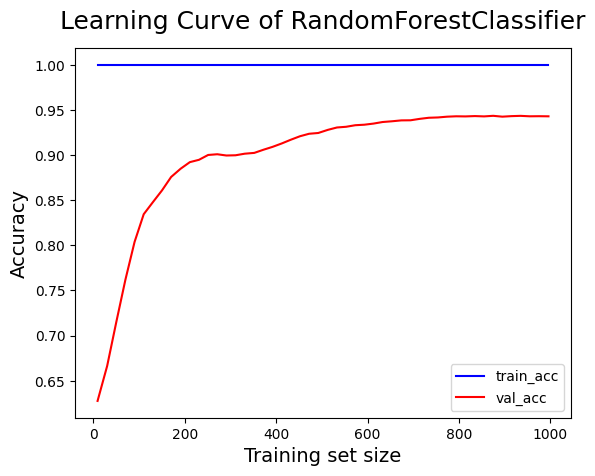

In [11]:
learning_analysis(model_architecture, X_train, y_train)

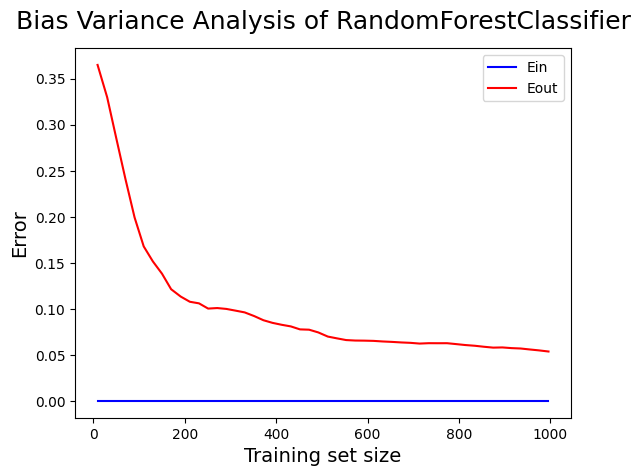

In [12]:
bias_variance_analysis(model_architecture, X_train, y_train)

In [13]:
# Fit the model
model = model_architecture.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
accuracy = model.score(X_test, y_test)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average='weighted', multi_class='ovr')

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)
print('AUC-ROC:', auc_roc)

Accuracy: 0.918918918918919
Precision: 0.9208709861682657
Recall: 0.918918918918919
F1-score: 0.919327983608685
AUC-ROC: 0.948061198061198


In [14]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           1       0.88      0.95      0.92        40
           2       0.81      0.78      0.80        55
           3       0.87      0.92      0.89       100
           4       0.99      0.95      0.97       175

    accuracy                           0.92       370
   macro avg       0.89      0.90      0.89       370
weighted avg       0.92      0.92      0.92       370

